# Analyse Exploratoire

### Import des modules

In [832]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import joblib


#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline

#Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

results = []
results_auc = []



In [833]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

def evaluate_classifier(name, model_or_class, X, y, model_params=None, cv=5):
    if callable(model_or_class):
        model = model_or_class(**(model_params or {}))
    else:
        model = model_or_class

    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }

    results_cv = cross_validate(
        model,
        X,
        y,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        scoring=scoring,
        return_train_score=True
    )
    
    print(f"📊 Model: {name}")
    print(f"→ Accuracy Test: {results_cv['test_accuracy'].mean():.3f}")
    print(f"→ Precision Test: {results_cv['test_precision'].mean():.3f}")
    print(f"→ Recall Test: {results_cv['test_recall'].mean():.3f}")
    print(f"→ F1-score Test: {results_cv['test_f1'].mean():.3f}")
    print(f"→ Accuracy Train: {results_cv['train_accuracy'].mean():.3f}")
    print(f"→ Precision Train: {results_cv['train_precision'].mean():.3f}")
    print(f"→ Recall Train: {results_cv['train_recall'].mean():.3f}")
    print(f"→ F1-score Train: {results_cv['train_f1'].mean():.3f}")
    print(f"→ Train Time: {(results_cv['fit_time'].mean() * 1000):.2f} ms")
    print(f"→ Predict Time: {(results_cv['score_time'].mean() * 1000):.2f} ms")

    results.append({
        "Model": name,
        "Accuracy Test":  round(results_cv["test_accuracy"].mean(), 3),
        "Precision Test": round(results_cv["test_precision"].mean(), 3),
        "Recall Test":    round(results_cv["test_recall"].mean(), 3),
        "F1 Test":        round(results_cv["test_f1"].mean(), 3),
        "Accuracy Train":  round(results_cv["train_accuracy"].mean(), 3),
        "Precision Train": round(results_cv["train_precision"].mean(), 3),
        "Recall Train":    round(results_cv["train_recall"].mean(), 3),
        "F1 Train":        round(results_cv["train_f1"].mean(), 3),
        "Train Time (ms)":   round(results_cv["fit_time"].mean() * 1000, 2),
        "Predict Time (ms)": round(results_cv["score_time"].mean() * 1000, 2),
    })


### Encodage / Validation des donneés

In [834]:
df = joblib.load("df.joblib")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   genre                                      1470 non-null   object  
 1   statut_marital                             1470 non-null   object  
 2   departement                                1470 non-null   object  
 3   poste                                      1470 non-null   object  
 4   nombre_experiences_precedentes             1470 non-null   int64   
 5   annee_experience_totale                    1470 non-null   int64   
 6   annees_dans_l_entreprise                   1470 non-null   int64   
 7   annees_dans_le_poste_actuel                1470 non-null   int64   
 8   a_quitte_l_entreprise                      1470 non-null   int64   
 9   nombre_participation_pee                   1470 non-null   int64   
 10  nb_formation

In [835]:

cat_cols = [
    'genre',
    'statut_marital',
    'departement',
    'poste',
    'domaine_etude',
    'frequence_deplacement',
    'heure_supplementaires',
    'tranche_age',
    'tranche_revenu',
    'tranche_distance',
]

num_cols = [
    'niveau_education',
    'nombre_experiences_precedentes',
    'augementation_salaire_precedente',
    'annee_experience_totale',
    'annees_dans_l_entreprise',
    'annees_dans_le_poste_actuel',
    'nombre_participation_pee',
    'nb_formations_suivies',
    'annees_depuis_la_derniere_promotion',
    'annes_sous_responsable_actuel',
    'note_evaluation_precedente',
    'note_evaluation_actuelle',
    'satisfaction_employee_environnement',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso',
]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)


In [836]:
# Drop la target a_quitte_l_entreprise

X = df.drop(columns=["a_quitte_l_entreprise"])

# Valeurs de la target

y = df.loc[X.index, "a_quitte_l_entreprise"]

In [837]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

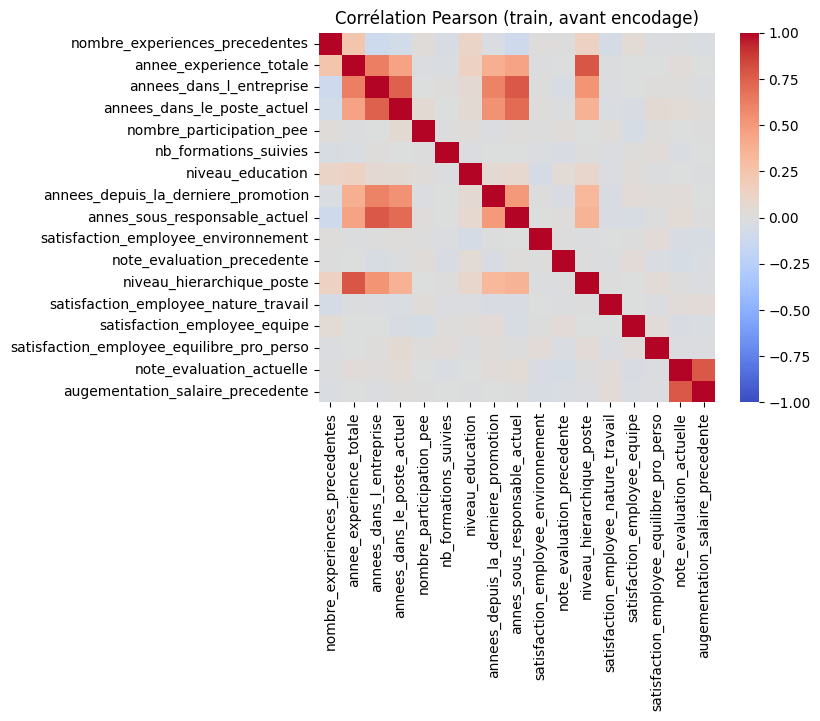

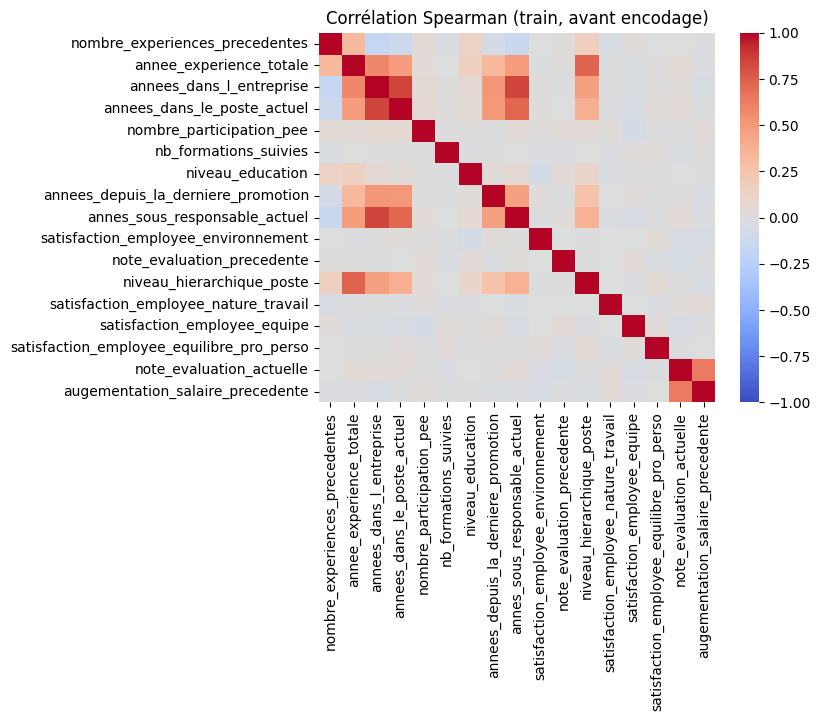

In [838]:
num_cols = X_train.select_dtypes(include='number').columns.tolist()

Xn = X_train[num_cols].copy()
Xn = Xn.fillna(Xn.median(numeric_only=True))

corr_p = Xn.corr(method='pearson')
corr_s = Xn.corr(method='spearman')

# Heatmap Pearson
sns.heatmap(corr_p, vmin=-1, vmax=1, cmap='coolwarm', center=0)
plt.title("Corrélation Pearson (train, avant encodage)")
plt.show()

# Heatmap Spearman
sns.heatmap(corr_s, vmin=-1, vmax=1, cmap='coolwarm', center=0)
plt.title("Corrélation Spearman (train, avant encodage)")
plt.show()

Comptes par classe :
 a_quitte_l_entreprise
0    1233
1     237
Name: count, dtype: int64

Proportions par classe :
 a_quitte_l_entreprise
0    0.839
1    0.161
Name: proportion, dtype: float64

Imbalance Ratio = 5.20


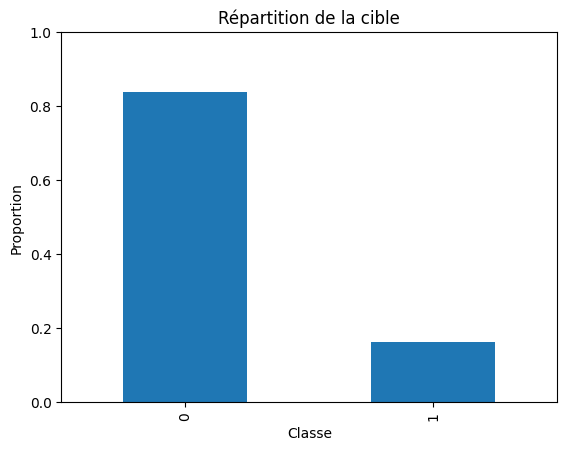

In [ ]:
counts = y.value_counts().sort_index()
props  = y.value_counts(normalize=True).sort_index()

print("Comptes par classe :\n", counts)
print("\nProportions par classe :\n", props.round(3))

imb_ratio = counts.max() / counts.min()
print(f"\nImbalance Ratio = {imb_ratio:.2f}")

# petit barplot
props.plot(kind='bar')
plt.title("Répartition de la cible")
plt.xlabel("Classe"); plt.ylabel("Proportion")
plt.ylim(0,1); plt.show()

# Hypothèses

## 1. Faux négatif (employé qui va partir, mais prédit comme "reste")
    ### Problème pour les RH car perd une personne, sans l'anticiper

## 2. Faux positif (employé qui reste, mais prédit comme "quitte l’entreprise")
    ### Problème mais pour moi moins grave car on peut le mettre dans un sorte de flux de sortie mais annulé si pas le cas

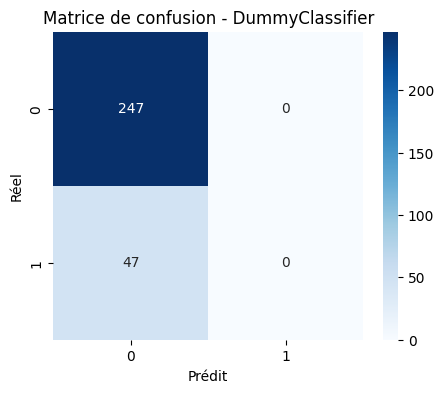

Rapport de classification - DummyClassifier :
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       247
           1       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.71      0.84      0.77       294

📊 Model: DummyClassifier
→ Accuracy Test: 0.839
→ Precision Test: 0.000
→ Recall Test: 0.000
→ F1-score Test: 0.000
→ Accuracy Train: 0.839
→ Precision Train: 0.000
→ Recall Train: 0.000
→ F1-score Train: 0.000
→ Train Time: 7.35 ms
→ Predict Time: 6.70 ms


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no pre

In [840]:

model = DummyClassifier(strategy='most_frequent')

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', model)
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - DummyClassifier")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

print("Rapport de classification - DummyClassifier :")
print(classification_report(y_test, y_pred))
evaluate_classifier("DummyClassifier", pipe, X, y)


AUC-ROC = 0.5000
AUC-ROC Train = 0.5000


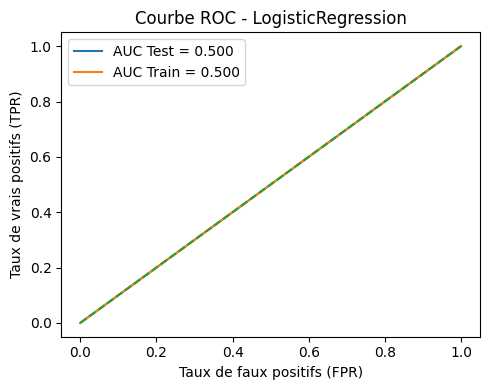

In [841]:

name = "DummyClassifier"

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC = {auc_roc:.4f}")

y_pred_proba_train = pipe.predict_proba(X_train)[:, 1]
auc_roc_train = roc_auc_score(y_train, y_pred_proba_train)
print(f"AUC-ROC Train = {auc_roc_train:.4f}")

# Courbe ROC TEST
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fprT, tprT, thresholdsT = roc_curve(y_train, y_pred_proba_train)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC Test = {auc_roc:.3f}")
plt.plot(fprT, tprT, label=f"AUC Train = {auc_roc_train:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC - LogisticRegression")
plt.legend()
plt.tight_layout()
plt.show()


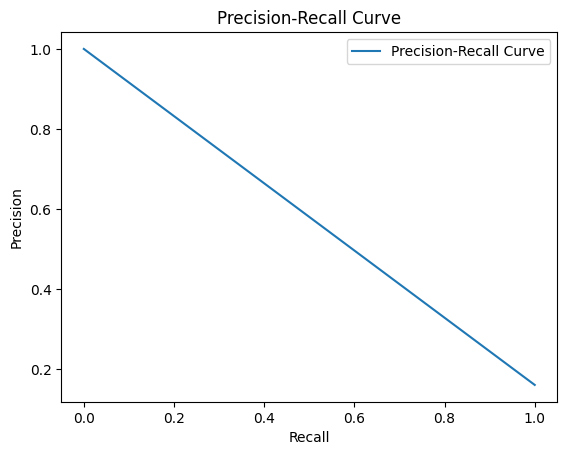

Average Precision (AUC-PR) Test = 0.1599
Average Precision (AUC-PR) Test = 0.1616


In [842]:
# Courbe PR
precision_test, recall_test, thresholds_test = precision_recall_curve(
    y_test, y_pred_proba
)
precision_train, recall_train, thresholds_train = precision_recall_curve(
    y_train, y_pred_proba_train
)

plt.plot(recall_test, precision_test, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


auc_pr = average_precision_score(y_test, y_pred_proba)
auc_pr_train = average_precision_score(y_train, y_pred_proba_train)
print(f"Average Precision (AUC-PR) Test = {auc_pr:.4f}")
print(f"Average Precision (AUC-PR) Test = {auc_pr_train:.4f}")


results_auc.append({
    "Model": name,
    "AUC-ROC Test":  round(auc_roc, 3),
    "AUC-PR Test":  round(auc_pr, 3),
    "AUC-ROC Train":  round(auc_roc_train, 3),
    "AUC-PR Train":  round(auc_pr_train, 3),
})

In [843]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(solver='saga', penalty='l2', max_iter=5000))
])

params = {
    'smote__sampling_strategy': [0.3, 0.5, 0.8, 1.0],  
    'smote__k_neighbors': [3, 5, 7],                  
    'classifier__C': np.logspace(-3, 2, 20),
}

rs2 = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params,
    n_iter=40,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=1
)

rs2.fit(X_train, y_train)
best_smote_lr = rs2.best_estimator_
print("Best AP (CV):", rs2.best_score_)
evaluate_classifier("LogisticRegression", best_smote_lr, X, y)




Fitting 5 folds for each of 40 candidates, totalling 200 fits


Best AP (CV): 0.663387859268313
📊 Model: LogisticRegression
→ Accuracy Test: 0.868
→ Precision Test: 0.609
→ Recall Test: 0.519
→ F1-score Test: 0.560
→ Accuracy Train: 0.896
→ Precision Train: 0.715
→ Recall Train: 0.591
→ F1-score Train: 0.647
→ Train Time: 157.72 ms
→ Predict Time: 9.91 ms


AUC-ROC = 0.8411
AUC-ROC Train = 0.8809


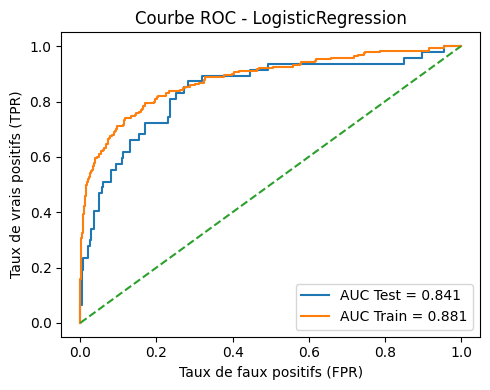

In [844]:
name = "LogisticRegression"

y_pred_proba = best_smote_lr.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC = {auc_roc:.4f}")

y_pred_proba_train = best_smote_lr.predict_proba(X_train)[:, 1]
auc_roc_train = roc_auc_score(y_train, y_pred_proba_train)
print(f"AUC-ROC Train = {auc_roc_train:.4f}")

# Courbe ROC TEST
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fprT, tprT, thresholdsT = roc_curve(y_train, y_pred_proba_train)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC Test = {auc_roc:.3f}")
plt.plot(fprT, tprT, label=f"AUC Train = {auc_roc_train:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC - LogisticRegression")
plt.legend()
plt.tight_layout()
plt.show()


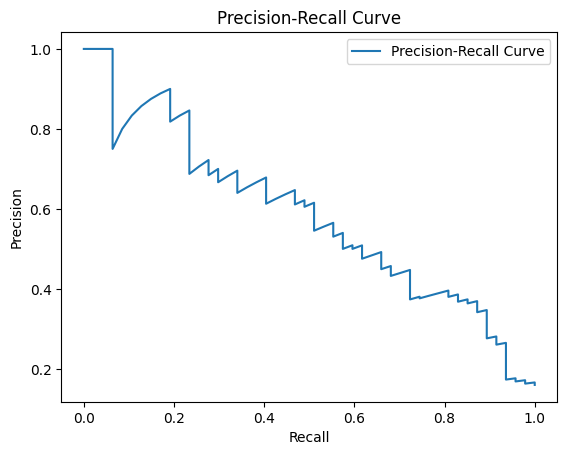

Average Precision (AUC-PR) Test = 0.5866
Average Precision (AUC-PR) Test = 0.7292


In [845]:
# Courbe PR
precision_test, recall_test, thresholds_test = precision_recall_curve(
    y_test, y_pred_proba
)
precision_train, recall_train, thresholds_train = precision_recall_curve(
    y_train, y_pred_proba_train
)

plt.plot(recall_test, precision_test, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


auc_pr = average_precision_score(y_test, y_pred_proba)
auc_pr_train = average_precision_score(y_train, y_pred_proba_train)
print(f"Average Precision (AUC-PR) Test = {auc_pr:.4f}")
print(f"Average Precision (AUC-PR) Test = {auc_pr_train:.4f}")


results_auc.append({
    "Model": name,
    "AUC-ROC Test":  round(auc_roc, 3),
    "AUC-PR Test":  round(auc_pr, 3),
    "AUC-ROC Train":  round(auc_roc_train, 3),
    "AUC-PR Train":  round(auc_pr_train, 3),
})

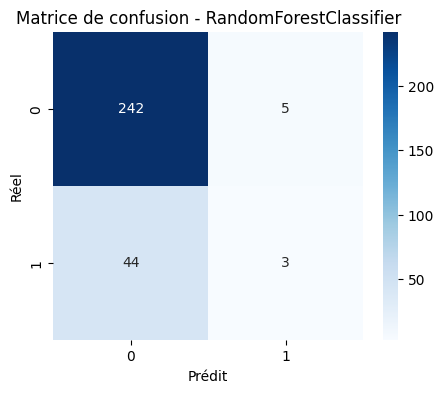

Rapport de classification - RandomForestClassifier
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.38      0.06      0.11        47

    accuracy                           0.83       294
   macro avg       0.61      0.52      0.51       294
weighted avg       0.77      0.83      0.78       294

📊 Model: RandomForestClassifier
→ Accuracy Test: 0.859
→ Precision Test: 0.866
→ Recall Test: 0.156
→ F1-score Test: 0.259
→ Accuracy Train: 0.910
→ Precision Train: 0.991
→ Recall Train: 0.447
→ F1-score Train: 0.616
→ Train Time: 987.79 ms
→ Predict Time: 178.84 ms


In [846]:
# RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model = RandomForestClassifier(random_state=42, class_weight='balanced')

pipe =  ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.3, k_neighbors=3, random_state=42)),  
    ('classifier', RandomForestClassifier(
        n_estimators=500, max_depth=12, min_samples_leaf=5,
        max_features='sqrt', class_weight=None, 
        random_state=42, n_jobs=-1
    ))
])


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - RandomForestClassifier")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

print("Rapport de classification - RandomForestClassifier")
print(classification_report(y_test, y_pred))
evaluate_classifier("RandomForestClassifier", pipe, X, y)


AUC-ROC = 0.7840
AUC-ROC Train = 0.9839


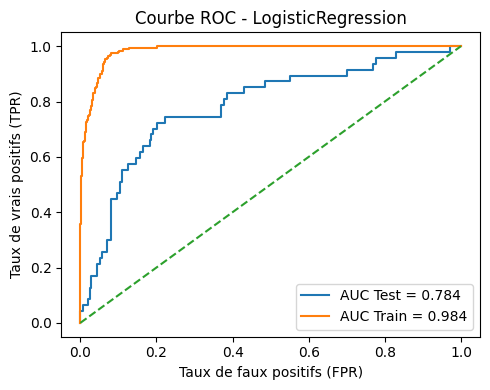

In [847]:
name = "RandomForestClassifier"

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC = {auc_roc:.4f}")

y_pred_proba_train = pipe.predict_proba(X_train)[:, 1]
auc_roc_train = roc_auc_score(y_train, y_pred_proba_train)
print(f"AUC-ROC Train = {auc_roc_train:.4f}")

# Courbe ROC TEST
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fprT, tprT, thresholdsT = roc_curve(y_train, y_pred_proba_train)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC Test = {auc_roc:.3f}")
plt.plot(fprT, tprT, label=f"AUC Train = {auc_roc_train:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC - LogisticRegression")
plt.legend()
plt.tight_layout()
plt.show()


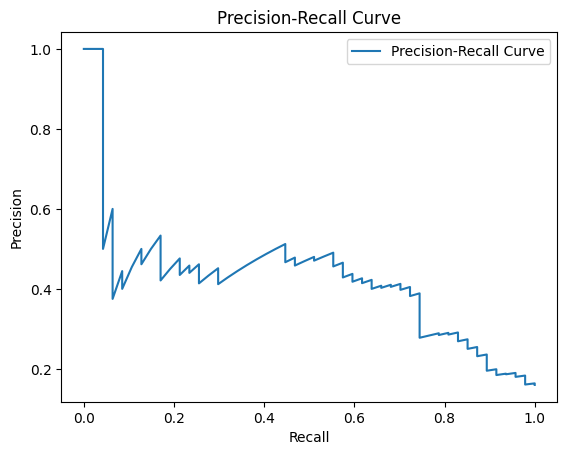

Average Precision (AUC-PR) Test = 0.4274
Average Precision (AUC-PR) Test = 0.9232


In [848]:
# Courbe PR
precision_test, recall_test, thresholds_test = precision_recall_curve(
    y_test, y_pred_proba
)
precision_train, recall_train, thresholds_train = precision_recall_curve(
    y_train, y_pred_proba_train
)

plt.plot(recall_test, precision_test, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


auc_pr = average_precision_score(y_test, y_pred_proba)
auc_pr_train = average_precision_score(y_train, y_pred_proba_train)
print(f"Average Precision (AUC-PR) Test = {auc_pr:.4f}")
print(f"Average Precision (AUC-PR) Test = {auc_pr_train:.4f}")


results_auc.append({
    "Model": name,
    "AUC-ROC Test":  round(auc_roc, 3),
    "AUC-PR Test":  round(auc_pr, 3),
    "AUC-ROC Train":  round(auc_roc_train, 3),
    "AUC-PR Train":  round(auc_pr_train, 3),
})

In [849]:
df_results = pd.DataFrame(results)
display(df_results) 

,Model,Accuracy Test,Precision Test,Recall Test,F1 Test,Accuracy Train,Precision Train,Recall Train,F1 Train,Train Time (ms),Predict Time (ms)
0,DummyClassifier,0.839,0.000,0.000,0.000,0.839,0.000,0.000,0.000,7.35,6.70
1,LogisticRegression,0.868,0.609,0.519,0.560,0.896,0.715,0.591,0.647,157.72,9.91
2,RandomForestClassifier,0.859,0.866,0.156,0.259,0.910,0.991,0.447,0.616,987.79,178.84


In [850]:
df_results_auc = pd.DataFrame(results_auc)
display(df_results_auc) 

,Model,AUC-ROC Test,AUC-PR Test,AUC-ROC Train,AUC-PR Train
0,DummyClassifier,0.500,0.160,0.500,0.162
1,LogisticRegression,0.841,0.587,0.881,0.729
2,RandomForestClassifier,0.784,0.427,0.984,0.923


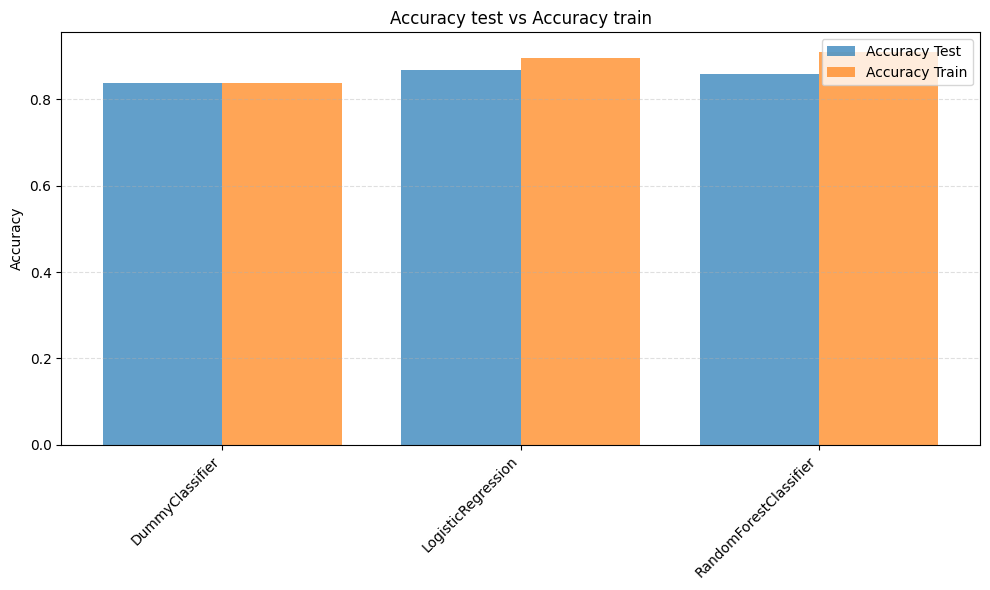

In [851]:
models = df_results["Model"].tolist()
accuracy_test = df_results["Accuracy Test"].tolist() 
accuracy_train = df_results["Accuracy Train"].tolist()

x = np.arange(len(models))
bar_width = 0.4

plt.figure(figsize=(10, 6))

plt.bar(x, accuracy_test, width=bar_width, label='Accuracy Test', alpha=0.7)
plt.bar(x + bar_width, accuracy_train, width=bar_width, label='Accuracy Train', alpha=0.7)

plt.xticks(x + bar_width / 2, models, rotation=45, ha='right')

plt.ylabel("Accuracy")
plt.title("Accuracy test vs Accuracy train")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)


plt.tight_layout()
plt.show()

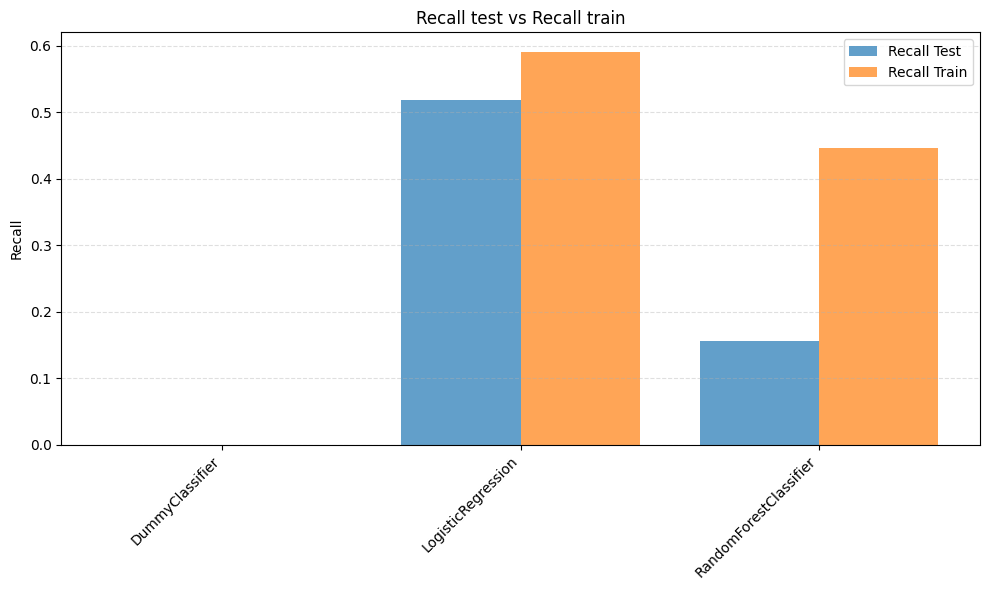

In [852]:
models = df_results["Model"].tolist()
recall_test = df_results["Recall Test"].tolist() 
recall_train = df_results["Recall Train"].tolist()

x = np.arange(len(models))
bar_width = 0.4

plt.figure(figsize=(10, 6))

plt.bar(x, recall_test, width=bar_width, label='Recall Test', alpha=0.7)
plt.bar(x + bar_width, recall_train, width=bar_width, label='Recall Train', alpha=0.7)

plt.xticks(x + bar_width / 2, models, rotation=45, ha='right')

plt.ylabel("Recall")
plt.title("Recall test vs Recall train")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)


plt.tight_layout()
plt.show()

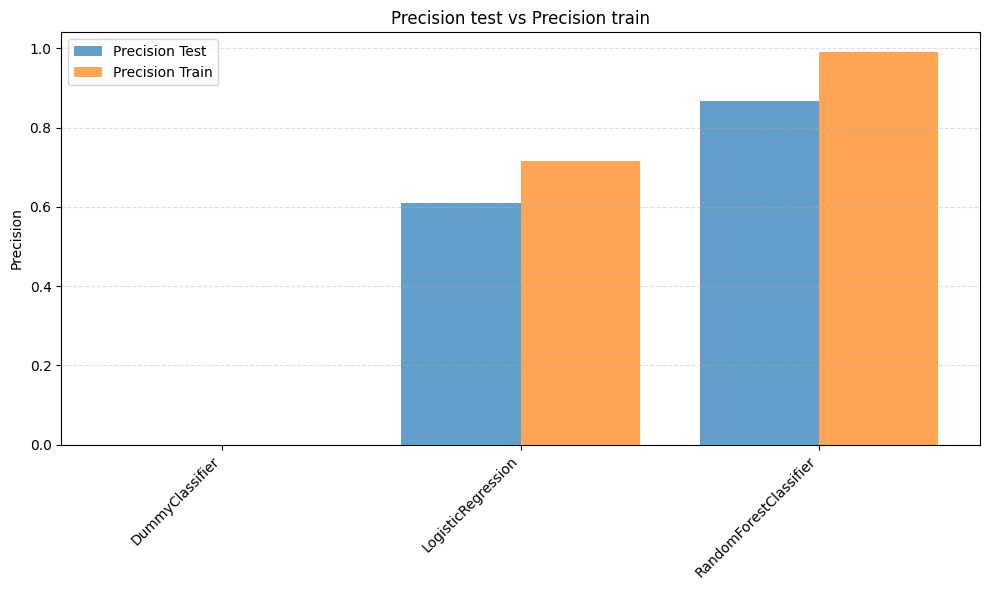

In [853]:
models = df_results["Model"].tolist()
precision_test = df_results["Precision Test"].tolist() 
precision_train = df_results["Precision Train"].tolist()

x = np.arange(len(models))
bar_width = 0.4

plt.figure(figsize=(10, 6))

plt.bar(x, precision_test, width=bar_width, label='Precision Test', alpha=0.7)
plt.bar(x + bar_width, precision_train, width=bar_width, label='Precision Train', alpha=0.7)

plt.xticks(x + bar_width / 2, models, rotation=45, ha='right')

plt.ylabel("Precision")
plt.title("Precision test vs Precision train")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)


plt.tight_layout()
plt.show()

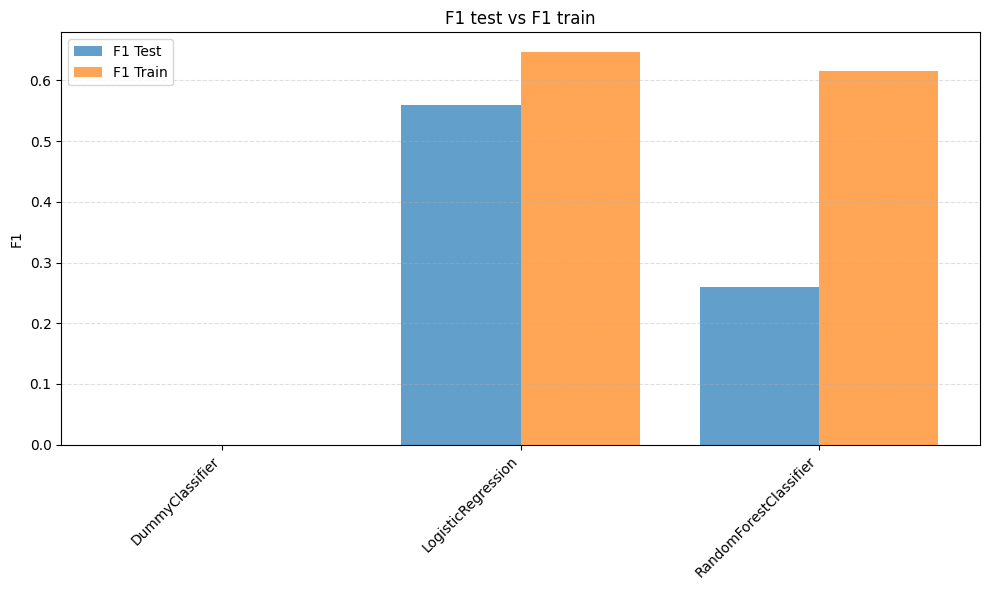

In [854]:
models = df_results["Model"].tolist()
f1_test = df_results["F1 Test"].tolist() 
f1_train = df_results["F1 Train"].tolist()

x = np.arange(len(models))
bar_width = 0.4

plt.figure(figsize=(10, 6))

plt.bar(x, f1_test, width=bar_width, label='F1 Test', alpha=0.7)
plt.bar(x + bar_width, f1_train, width=bar_width, label='F1 Train', alpha=0.7)

plt.xticks(x + bar_width / 2, models, rotation=45, ha='right')

plt.ylabel("F1")
plt.title("F1 test vs F1 train")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)


plt.tight_layout()
plt.show()

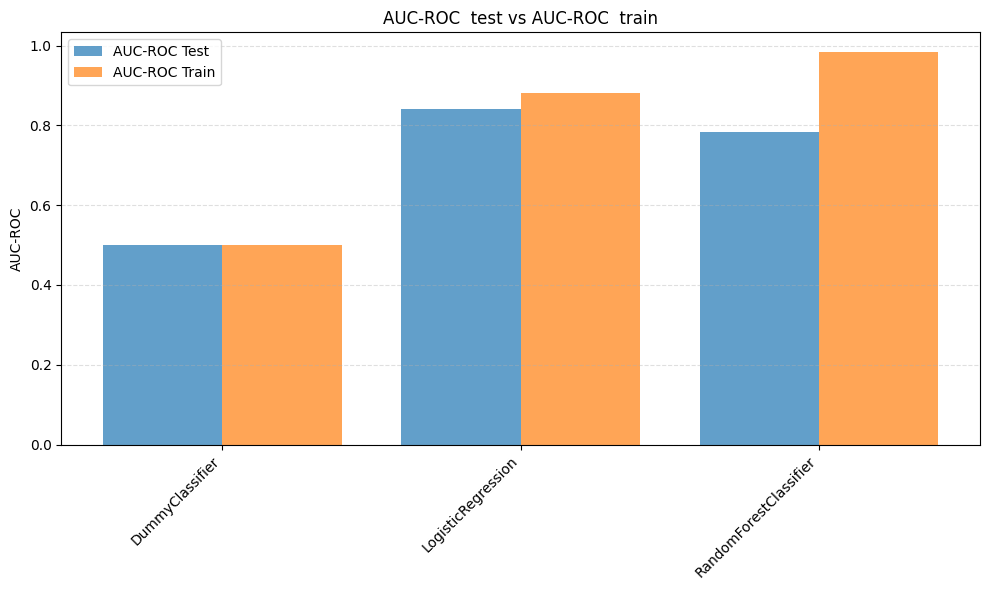

In [855]:
models = df_results_auc["Model"].tolist()
auc_roc_test = df_results_auc["AUC-ROC Test"].tolist() 
auc_roc_train = df_results_auc["AUC-ROC Train"].tolist()

x = np.arange(len(models))
bar_width = 0.4

plt.figure(figsize=(10, 6))

plt.bar(x, auc_roc_test, width=bar_width, label='AUC-ROC Test', alpha=0.7)
plt.bar(x + bar_width, auc_roc_train, width=bar_width, label='AUC-ROC Train', alpha=0.7)

plt.xticks(x + bar_width / 2, models, rotation=45, ha='right')

plt.ylabel("AUC-ROC")
plt.title("AUC-ROC  test vs AUC-ROC  train")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)


plt.tight_layout()
plt.show()

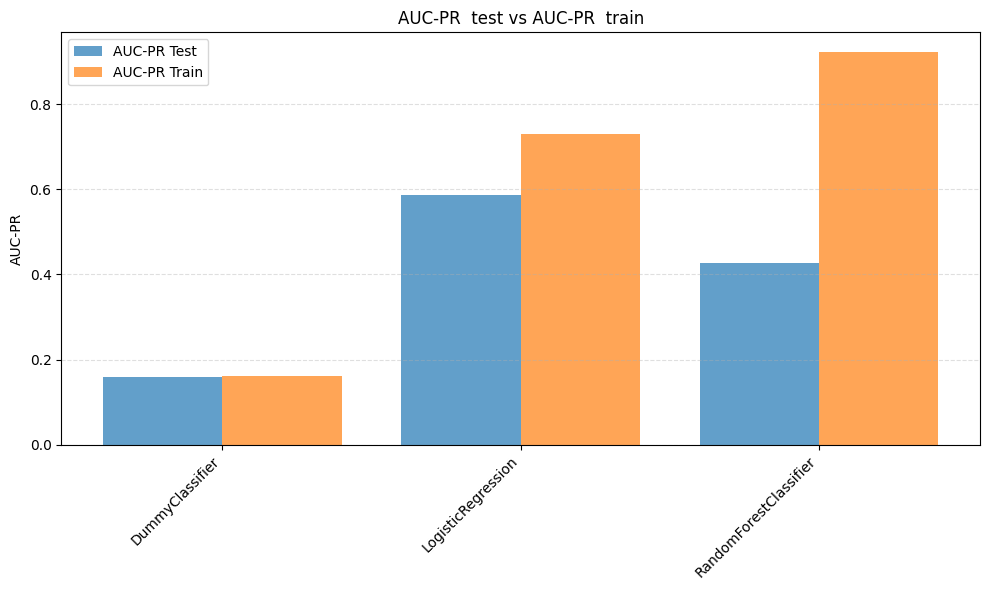

In [856]:
models = df_results_auc["Model"].tolist()
auc_pr_test = df_results_auc["AUC-PR Test"].tolist() 
auc_pr_train = df_results_auc["AUC-PR Train"].tolist()

x = np.arange(len(models))
bar_width = 0.4

plt.figure(figsize=(10, 6))

plt.bar(x, auc_pr_test, width=bar_width, label='AUC-PR Test', alpha=0.7)
plt.bar(x + bar_width, auc_pr_train, width=bar_width, label='AUC-PR Train', alpha=0.7)

plt.xticks(x + bar_width / 2, models, rotation=45, ha='right')

plt.ylabel("AUC-PR")
plt.title("AUC-PR  test vs AUC-PR  train")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)


plt.tight_layout()
plt.show()

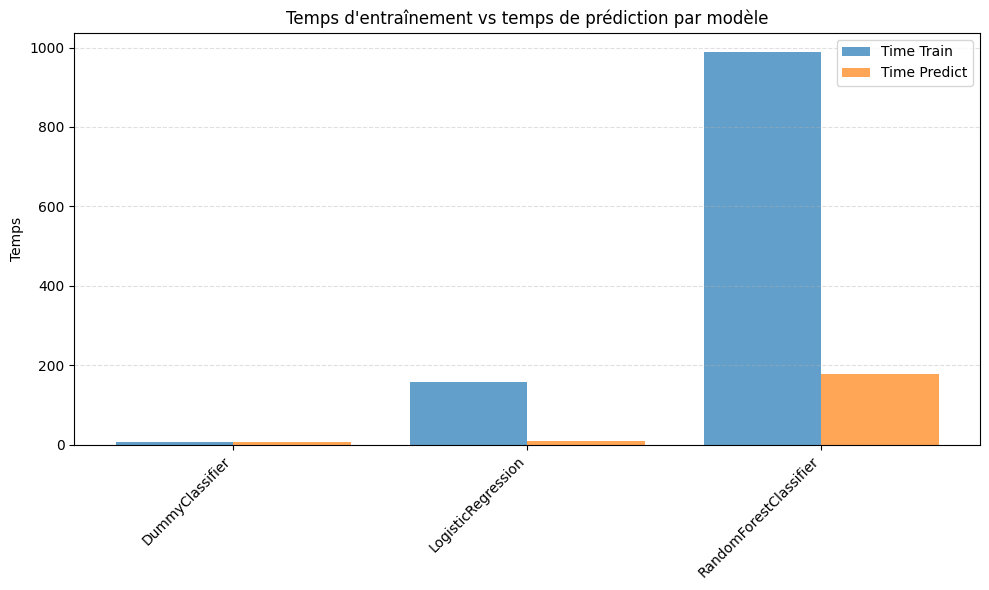

In [ ]:
models = df_results["Model"].tolist()
time_train = df_results["Train Time (ms)"].tolist() 
time_predict = df_results["Predict Time (ms)"].tolist()

x = np.arange(len(models))
bar_width = 0.4

plt.figure(figsize=(10, 6))

plt.bar(x, time_train, width=bar_width, label='Time Train', alpha=0.7)
plt.bar(x + bar_width, time_predict, width=bar_width, label='Time Predict', alpha=0.7)

plt.xticks(x + bar_width / 2, models, rotation=45, ha='right')

plt.ylabel("Temps")
plt.title("Temps d'entraînement vs temps de prédiction par modèle")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.yscale('log')

plt.tight_layout()
plt.show()

### SMOTE 

In [858]:

model = LogisticRegression(max_iter=2000) 

pipe = Pipeline([
    ('preprocessing', preprocessor),               
    ('smote', SMOTE(random_state=42)),             
    ('classifier', model),
])

param_grid = {
    'smote__k_neighbors': [2, 3, 5],
    'smote__sampling_strategy': [0.5, 0.8, 1.0],
    'classifier__C': np.logspace(-3, 2, 6),      
    'classifier__class_weight': ['balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe, param_grid,
    scoring='f1_weighted',
    cv=cv, n_jobs=-1, refit=True, verbose=1
)

grid.fit(X_train, y_train.ravel())

print("Meilleur params:", grid.best_params_)
print("Meilleur CV score:", grid.best_score_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))


Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Meilleur params: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.8}
Meilleur CV score: 0.8114161978653547
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       247
           1       0.44      0.74      0.55        47

    accuracy                           0.81       294
   macro avg       0.69      0.78      0.71       294
weighted avg       0.86      0.81      0.82       294



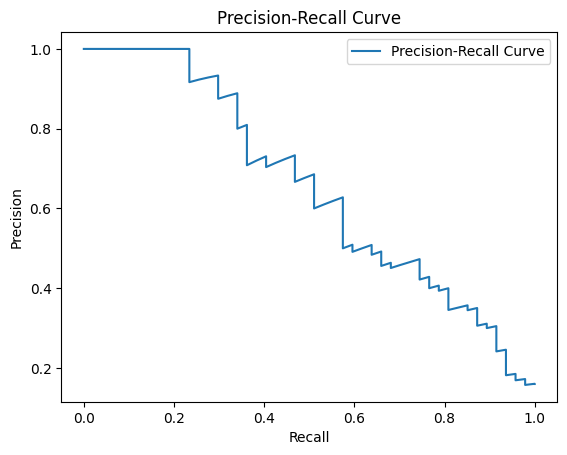

In [859]:
# Nom du modèle
name = "LogisticRegression + SMOTE (best params)"

y_pred_proba = grid.predict_proba(X_test)[:, 1]

precision_test, recall_test, thresholds_test = precision_recall_curve(
    y_test, y_pred_proba
)

plt.plot(recall_test, precision_test, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()



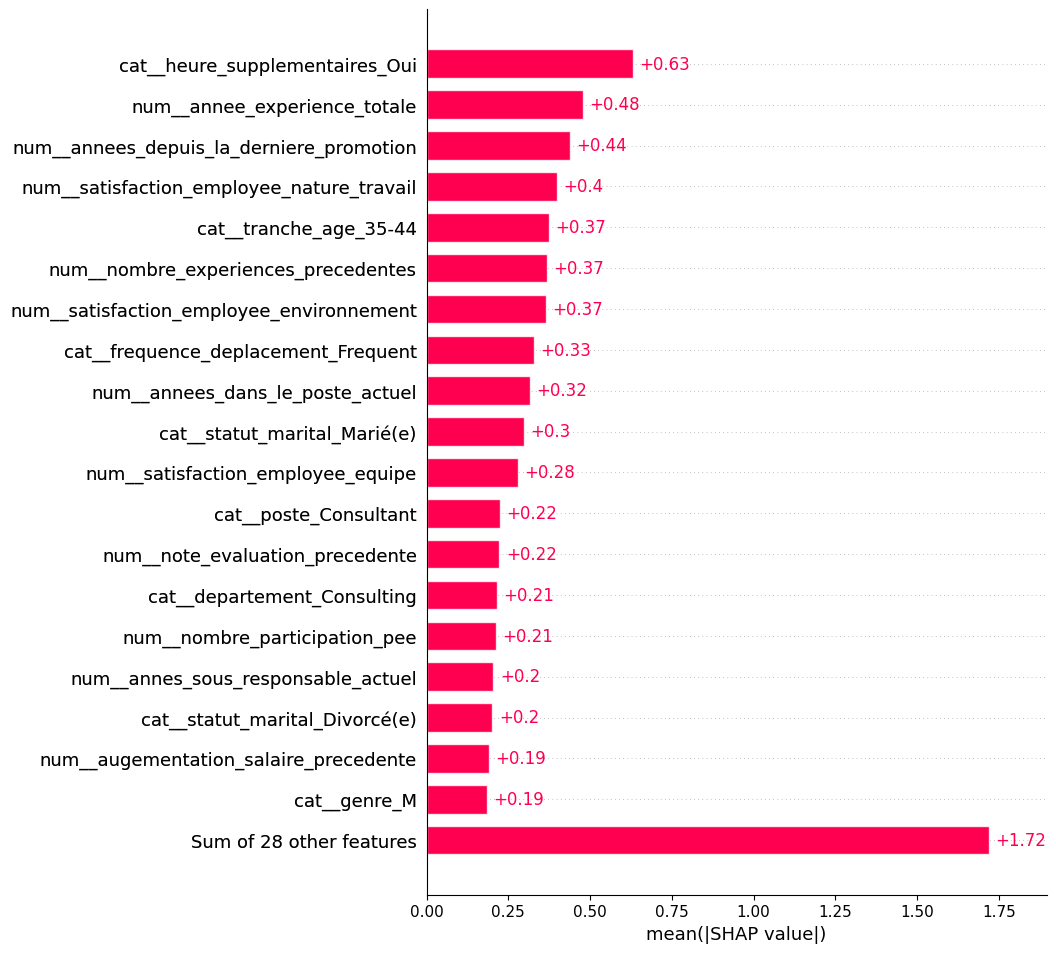

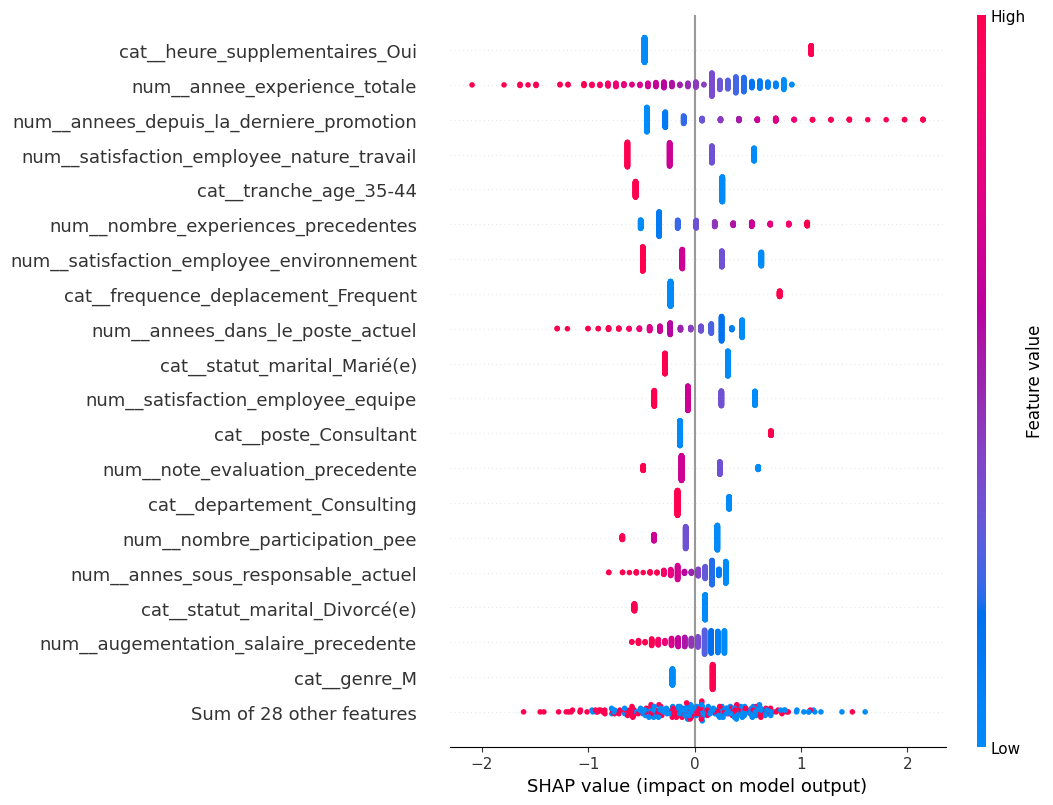

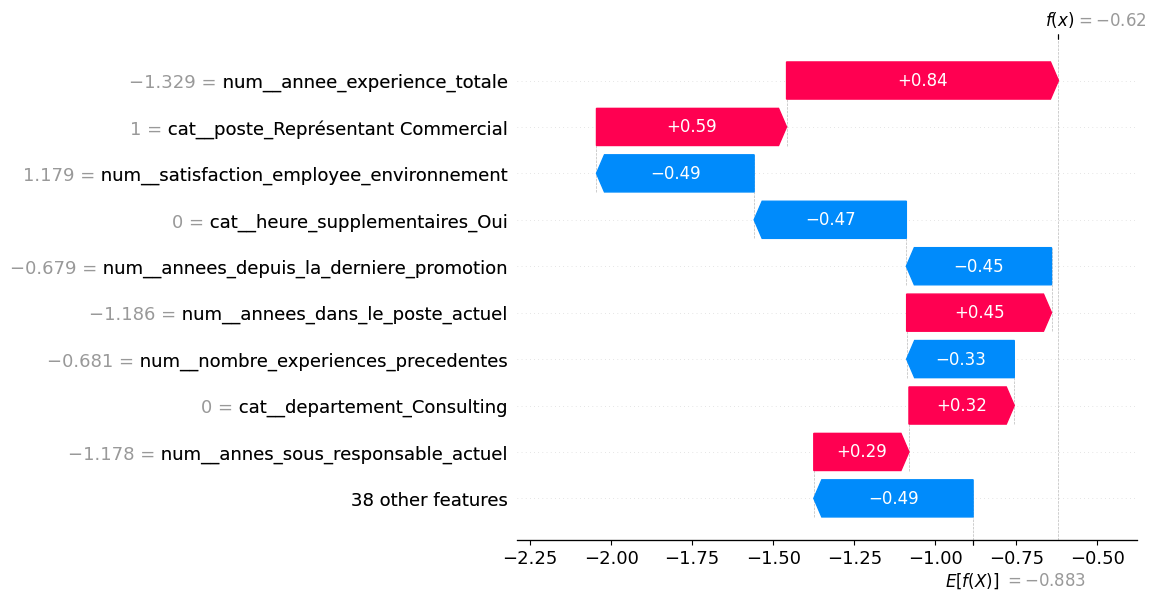

In [860]:
import shap
import pandas as pd
import numpy as np

best_pipe = grid.best_estimator_
pre  = best_pipe.named_steps['preprocessing']
clf  = best_pipe.named_steps['classifier']

Xtr = pre.transform(X_train)
Xte = pre.transform(X_test)
feat = pre.get_feature_names_out()

def to_df(X):
    return pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X,
                        columns=feat)

Xtr_df, Xte_df = to_df(Xtr), to_df(Xte)

explainer = shap.LinearExplainer(clf, Xtr_df, link=shap.links.logit)
sv = explainer(Xte_df)   

mean_abs = pd.Series(
    np.abs(sv.values).mean(axis=0),
    index=feat
).sort_values(ascending=False)


shap.plots.bar(sv, max_display=20)      
shap.plots.beeswarm(sv, max_display=20) 

shap.plots.waterfall(sv[0], max_display=10)
